# TP Integrador - Redes Neuronales.

Clasificación para determinar si un hongo es comestible o no teniendo en cuenta distintas caracteristicas fisicas del mismo.


data set: https://www.kaggle.com/datasets/prishasawhney/mushroom-dataset

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
import seaborn as sns

### Lectura y analisis del CSV

In [14]:
csv = pd.read_csv('mushroom.csv')
csv.isnull().sum()

cap-diameter       0
cap-shape          0
gill-attachment    0
gill-color         0
stem-height        0
stem-width         0
stem-color         0
season             0
class              0
dtype: int64

In [15]:
#csv.fillna(csv.median(), inplace=True)
csv.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000,54035.000000
mean,567.257204,4.000315,2.142056,7.329509,0.759110,1051.081299,8.418062,0.952163,0.549181
std,359.883763,2.160505,2.228821,3.200266,0.650969,782.056076,3.262078,0.305594,0.497580
min,0.000000,0.000000,0.000000,0.000000,0.000426,0.000000,0.000000,0.027372,0.000000
25%,289.000000,2.000000,0.000000,5.000000,0.270997,421.000000,6.000000,0.888450,0.000000
50%,525.000000,5.000000,1.000000,8.000000,0.593295,923.000000,11.000000,0.943195,1.000000
75%,781.000000,6.000000,4.000000,10.000000,1.054858,1523.000000,11.000000,0.943195,1.000000
max,1891.000000,6.000000,6.000000,11.000000,3.835320,3569.000000,12.000000,1.804273,1.000000


Por medio del histograma podemos ver que hay valores atipicos en la columna 'gill-color'

Es por esto que se descarta un 10% de cada extremo luego de ordenar el csv por esa columna

array([[<Axes: title={'center': 'cap-diameter'}>,
        <Axes: title={'center': 'cap-shape'}>,
        <Axes: title={'center': 'gill-attachment'}>],
       [<Axes: title={'center': 'gill-color'}>,
        <Axes: title={'center': 'stem-height'}>,
        <Axes: title={'center': 'stem-width'}>],
       [<Axes: title={'center': 'stem-color'}>,
        <Axes: title={'center': 'season'}>,
        <Axes: title={'center': 'class'}>]], dtype=object)

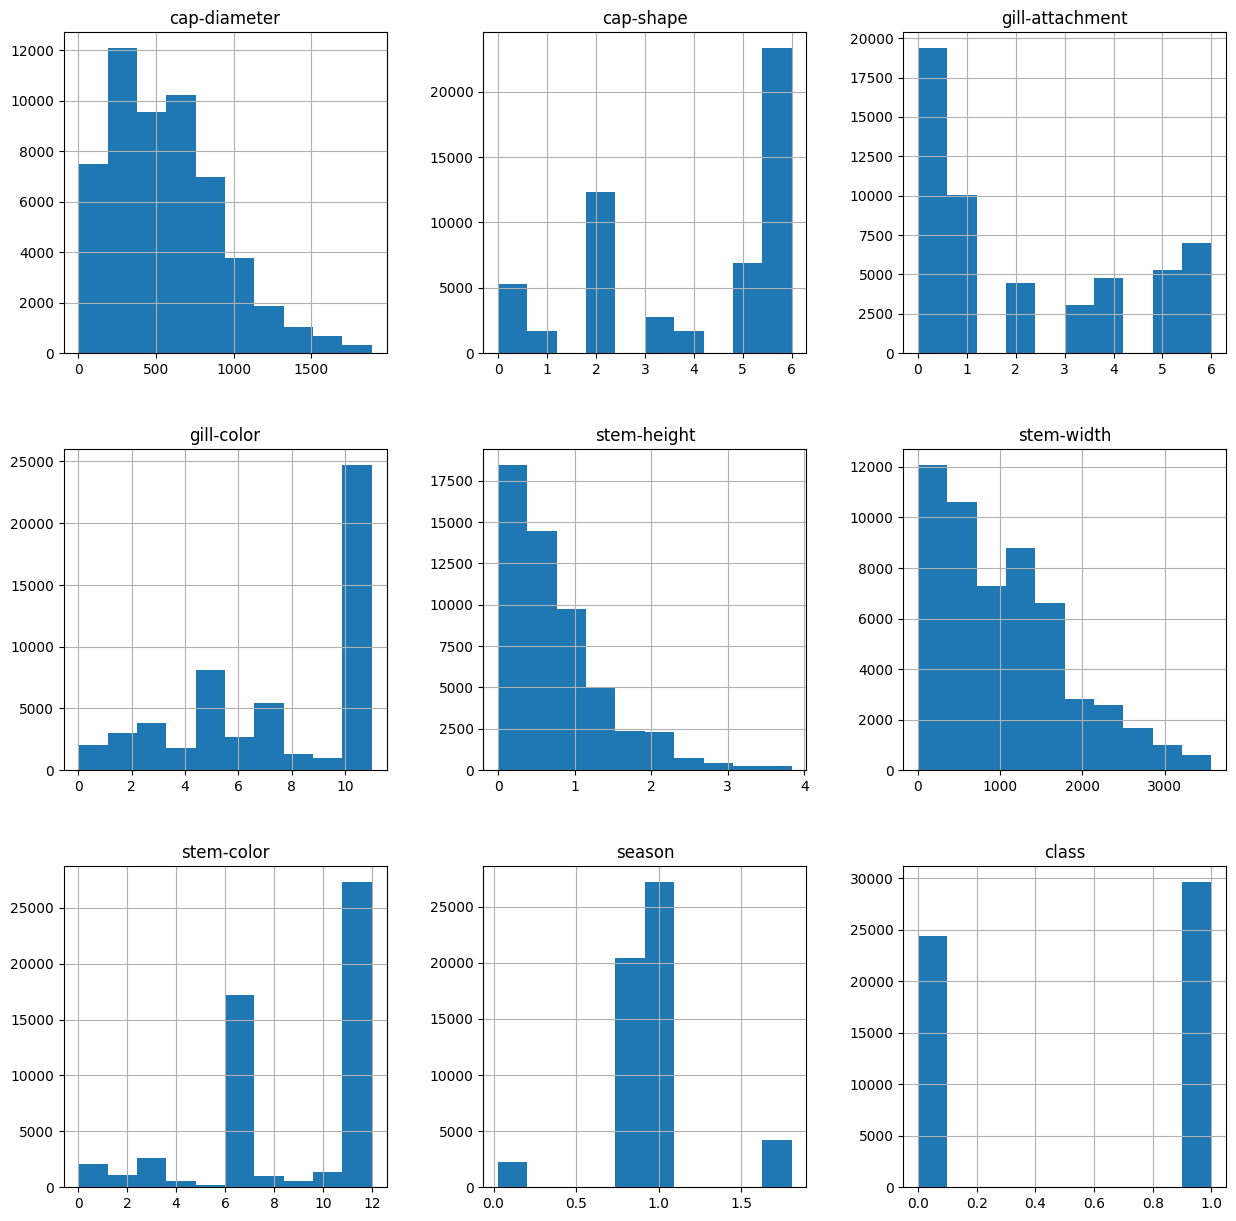

In [16]:
csv.corr()
csv.hist(figsize=(15,15))

In [17]:

csv_sorted = csv.sort_values(by='gill-color')

n_rows = len(csv_sorted)

ten_percent = int(0.10 * n_rows)

csv_trimmed = csv_sorted.iloc[ten_percent:-ten_percent]

csv_trimmed.to_csv('mushroom_trimmed.csv', index=False)

csv = pd.read_csv('mushroom_trimmed.csv')

Normalizacion de los datos despues de descartar los valores atipicos

In [18]:
csv_data = csv.drop('class', axis=1)
crop = csv['class']
csv_stats = csv_data.describe().T
csv_data_n = (csv_data - csv_stats['mean']) / csv_stats['std']
csv_n = pd.concat([csv_data_n, crop], axis=1)
csv_n.describe()

,cap-diameter,cap-shape,gill-attachment,gill-color,stem-height,stem-width,stem-color,season,class
count,4.322900e+04,4.322900e+04,4.322900e+04,4.322900e+04,4.322900e+04,4.322900e+04,4.322900e+04,4.322900e+04,43229.000000
mean,-4.207799e-17,1.656821e-16,6.574686e-18,2.103899e-17,3.175573e-16,-3.287343e-17,1.577925e-16,1.380684e-16,0.556085
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,0.496850
min,-1.560368e+00,-1.779527e+00,-8.568796e-01,-1.772119e+00,-1.142462e+00,-1.325269e+00,-2.731917e+00,-3.091286e+00,0.000000
25%,-7.774431e-01,-8.807400e-01,-8.568796e-01,-1.001193e+00,-7.496318e-01,-8.364183e-01,-7.947932e-01,-2.488793e-01,0.000000
50%,-1.055712e-01,4.674402e-01,-4.111323e-01,1.551964e-01,-2.583830e-01,-1.916643e-01,8.194765e-01,-6.816925e-02,1.000000
75%,5.996167e-01,9.168337e-01,9.261097e-01,9.261227e-01,4.523109e-01,5.984235e-01,8.194765e-01,-6.816925e-02,1.000000
max,3.686896e+00,9.168337e-01,1.817604e+00,1.311586e+00,4.508346e+00,3.390155e+00,1.142330e+00,2.774238e+00,1.000000


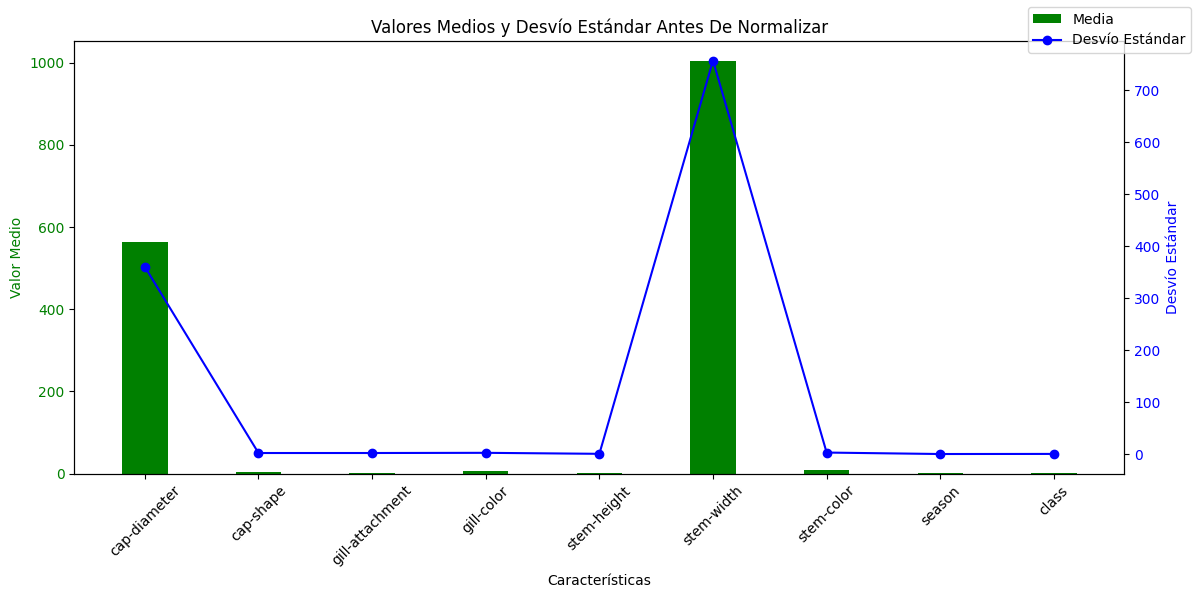

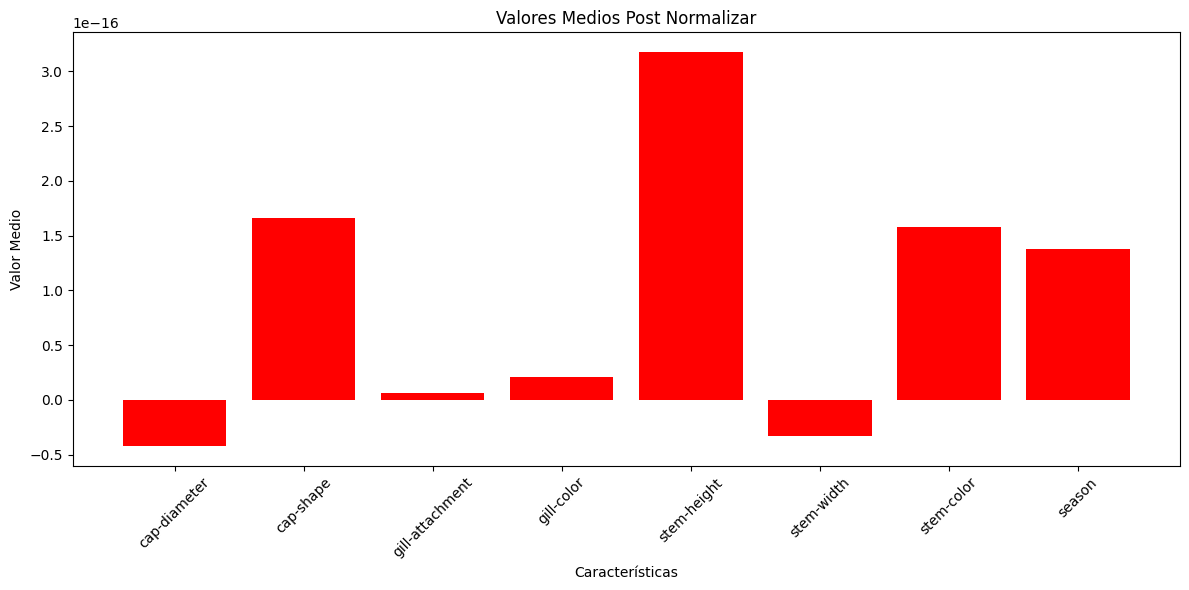

In [19]:
fig, ax1 = plt.subplots(figsize=(12, 6))

bar_width = 0.4
x = np.arange(len(csv.columns))

ax1.bar(x, csv.describe().loc['mean'], bar_width, color='green', label='Media')
ax1.set_xlabel('Características')
ax1.set_ylabel('Valor Medio', color='green')
ax1.tick_params(axis='y', labelcolor='green')
ax1.set_xticks(x)
ax1.set_xticklabels(csv.columns, rotation=45)
ax1.set_title('Valores Medios y Desvío Estándar Antes De Normalizar')

ax2 = ax1.twinx()
ax2.plot(x, csv.describe().loc['std'], color='blue', marker='o', label='Desvío Estándar')
ax2.set_ylabel('Desvío Estándar', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.tight_layout()
fig.legend(loc='upper right')

plt.show()

plt.figure(figsize=(12, 6))
plt.bar(csv_data_n.columns, csv_data_n.describe().loc['mean'], color='red')
plt.title('Valores Medios Post Normalizar')
plt.xlabel('Características')
plt.ylabel('Valor Medio')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

<Axes: >

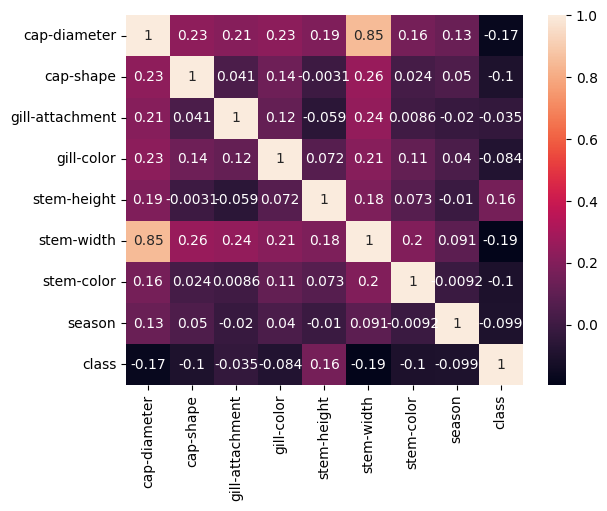

In [20]:
sns.heatmap(csv.corr() ,annot= True)

Division de los datos para la red neuronal y para usar con Scikit Learn

Se utilizo un 70% de la muestra para entrenar el modelo

In [21]:
X_drop = csv_n.drop(['class'],axis=1)

X = X_drop.values
Y = csv_n['class'].values

X_train, X_test, Y_train, Y_test = train_test_split(X, Y,test_size=0.3)

### Forward Propagation

Se utilizaron dos capas ocultas de 20 neuronas cada una.

La funcion de activacion es ReLu y la funcion de salida es Logistic

In [22]:


input_size = X_train.shape[1] # Número de características de entrada
hidden1_size = 20  # Tamaño de la primera capa oculta
hidden2_size = 20 # Tamaño de la segunda capa oculta
output_size = 1  # Tamaño de la capa de salida

# Pesos
w_hidden1 = np.random.rand(hidden1_size, input_size)
w_hidden2 = np.random.rand(hidden2_size, hidden1_size)
w_output = np.random.rand(output_size, hidden2_size)
# Sesgos
b_hidden1 = np.random.rand(hidden1_size, 1)
b_hidden2 = np.random.rand(hidden2_size, 1)
b_output = np.random.rand(output_size, 1)

# Funciones de activación
relu = lambda x: np.maximum(x, 0)
#softmax = lambda x: np.exp(x) / np.sum(np.exp(x), axis=0)
logistic = lambda x: 1 / (1 + np.exp(-x))

# Derivadas de las funciones de activación
d_relu = lambda x: x > 0
d_logistic = lambda x: np.exp(-x) / (1 + np.exp(-x)) ** 2

# Función que ejecuta la propagación hacia adelante de la red neuronal
def forward_prop(X):
    Z1 = w_hidden1 @ X + b_hidden1
    A1 = relu(Z1)
    Z2 = w_hidden2 @ A1 + b_hidden2
    A2 = relu(Z2)
    Z3 = w_output @ A2 + b_output
    A3 = logistic(Z3)
    return Z1, A1, Z2, A2, Z3, A3

# Cálculo de precisión
test_predictions = forward_prop(X_test.transpose())[-1]
test_comparisons = np.equal((test_predictions >= .5).astype(int), Y_test)
accuracy = np.mean(test_comparisons.astype(int))
print("Accuracy:", accuracy)

Accuracy: 0.5607217210270645


### Backpropagation

Se configuro con 100000 iteraciones y una tasa de aprendizaje del 0.0001

In [23]:
L = .0001  # La tasa de aprendizaje
I = 100_000 # Cant de iteraciones

# Devuelve pendientes para pesos y sesgos
# usando la regla de la cadena
def backward_prop(Z1, A1, Z2, A2, Z3, A3, X, Y):
    dC_dA3 = 2*A3 - 2*Y
    dA3_dZ3 = d_logistic(Z3)
    dZ3_dA2 = w_output
    dZ3_dW3 = A2
    dZ3_dB3 = 1
    dA2_dZ2 = d_relu(Z2)
    dZ2_dA1 = w_hidden2
    dZ2_dW2 = A1
    dZ2_dB2 = 1
    dA1_dZ1 = d_relu(Z1)
    dZ1_dW1 = X
    dZ1_dB1 = 1

    dC_dW3 = dC_dA3 @ dA3_dZ3 @ dZ3_dW3.T

    dC_dB3 = dC_dA3 @ dA3_dZ3 * dZ3_dB3

    dC_dA2 = dC_dA3 @ dA3_dZ3 @ dZ3_dA2

    dC_dW2 = dC_dA2 @ dA2_dZ2 @ dZ2_dW2.T

    dC_dB2 = dC_dA2 @ dA2_dZ2 * dZ2_dB2

    dC_dA1 = dC_dA2 @ dZ2_dA1

    dC_dW1 = dC_dA1 @ dA1_dZ1 @ dZ1_dW1.T

    dC_dB1 = dC_dA1 @ dA1_dZ1 * dZ1_dB1

    return dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3

# Ejecutar descenso de gradiente
n = X_train.shape[0]
print(n)
for i in range(I):
    # seleccionar aleatoriamente un conjunto de datos de entrenamiento
    idx = np.random.choice(n, 1, replace=False)
    X_sample = X_train[idx].transpose()
    Y_sample = Y_train[idx]

    # pasar datos seleccionados aleatoriamente a través de la red neuronal
    Z1, A1, Z2, A2, Z3, A3 = forward_prop(X_sample)

    dC_dW1, dC_dB1, dC_dW2, dC_dB2, dC_dW3, dC_dB3 = backward_prop(Z1, A1, Z2, A2, Z3, A3, X_sample, Y_sample)

    # actualizar pesos y sesgos
    w_hidden1 -= L * dC_dW1
    b_hidden1 -= L * dC_dB1
    w_hidden2 -= L * dC_dW2
    b_hidden2 -= L * dC_dB2
    w_output -= L * dC_dW3
    b_output -= L * dC_dB3


# Cálculo de precisión
test_predictions = forward_prop(X_test.transpose())[3]
test_predictions = (test_predictions >= 0.5).astype(int)  # Convertir las predicciones en valores binarios
accuracy = np.mean(test_predictions == Y_test.reshape(1, -1))  # Calcular la precisión comparando las predicciones con los valores reales

print("Accuracy: ", accuracy)

30260
Accuracy:  0.5347867992906161


### Comparacion con Scikit Learn

In [24]:
model = MLPClassifier(
	                solver='sgd', 
                    hidden_layer_sizes=(20, 20),
                    activation='relu',
                    max_iter=100_000,
                    learning_rate_init=.0001,
                    verbose=True,
                    random_state=42,
                    tol=1e-6)

model.fit(X_train, Y_train)

# Realizar predicciones
y_pred = model.predict(X_test)

# Calcular la precisión del modelo

print("Puntaje del conjunto de entrenamiento: %f" % model.score(X_train, Y_train))
print("Puntaje del conjunto de prueba: %f" % model.score(X_test, Y_test))

Iteration 1, loss = 0.77025859
Iteration 2, loss = 0.74422220
Iteration 3, loss = 0.72668548
Iteration 4, loss = 0.71447723
Iteration 5, loss = 0.70570629
Iteration 6, loss = 0.69916172
Iteration 7, loss = 0.69418128
Iteration 8, loss = 0.69022381
Iteration 9, loss = 0.68700674
Iteration 10, loss = 0.68426018
Iteration 11, loss = 0.68187308
Iteration 12, loss = 0.67974090
Iteration 13, loss = 0.67780908
Iteration 14, loss = 0.67603237
Iteration 15, loss = 0.67438101
Iteration 16, loss = 0.67282547
Iteration 17, loss = 0.67135470
Iteration 18, loss = 0.66996042
Iteration 19, loss = 0.66861923
Iteration 20, loss = 0.66733870
Iteration 21, loss = 0.66610818
Iteration 22, loss = 0.66492068
Iteration 23, loss = 0.66377661
Iteration 24, loss = 0.66266447
Iteration 25, loss = 0.66158860
Iteration 26, loss = 0.66054047
Iteration 27, loss = 0.65952112
Iteration 28, loss = 0.65852696
Iteration 29, loss = 0.65755636
Iteration 30, loss = 0.65661039
Iteration 31, loss = 0.65568526
Iteration 32, los

El modelo hecho con Scikit Learn resulto tener mucha mas exactitud que el modelo manual.

Intente buscar en la red donde se puede estar perdiendo ese ~40% de exactitud pero no logre dar con el error en el codigo.

Asumo que es un error en la parte de Backpropagation ya que en el modelo de Scikit Learn se usaron las mismas configuraciones.